In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

keys = ['采集时间', '水温', 'pH', '溶解氧', '电导率', '浊度', '高锰酸盐指数','氨氮', '总磷', '总氮']
en_keys = ['WaterTemperature', 'PH' ,'dissolved oxygen', 'Conductivity','Turbidity','PermanganateIndex',
        'AmmoniaNitrogen','TP','TN', 'humidity','room temperature','chlorophyll','Algae density']
# limits = [(5, 30), (5.0, 9), (1, 15), (50, 500), (0, 1500), (0, 15), (0, 0.5), (0, 0.3), (0, 5)]
# np.set_printoptions(formatter = {'float': '{:.2e}'.format})

def patch_up(df, size=7):
    '''
    patch up the missing data by the mean value of previous and next seven days' data.
    '''
    step = 2 * size + 1
    group = df.groupby([df.index.hour])
    dfns = [pd.DataFrame(group.get_group(k)) for k in group.groups.keys()]
    dfns = [dfn.rolling(step, center=True, min_periods=1).mean() for dfn in dfns]
    print(dfns[2]['氨氮'].index[dfns[2]['氨氮'].isna()])
    # Fix the rows with no true value at all. 
    all_nan_idx = df.index[df.isna().all(axis=1)]
    for idx in all_nan_idx:
        k = idx.hour // 4
        df.loc[idx] =  dfns[k].loc[str(idx.date())].values
    
    # Fix the rows with true values and nan.
    for k in df.keys():
        nan_idx = df[k].index[df[k].isna()]
        for idx in nan_idx:
            hour = idx.hour // 4
            df[k].loc[idx] = dfns[hour][k].loc[str(idx.date())]
    return df

In [21]:
df = pd.read_excel('./origional_data/泸沽湖邛海鲁班水库水质数据/原始查询/原始查询（鲁班岛-鲁班水库）.xls', 
                   header=2, usecols=keys, index_col=0)
df = df.loc[::-1]
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
df.replace(to_replace= '--', value = np.nan, inplace=True)
df = df.astype('float64')
df[df < 0] = np.nan
# df = df.drop(df[df.index <= '2019-02-07'].index)
# for date in find_miss(df): print(date.date())
# # print(find_miss(df))
df = df.resample('4H', 'index').mean()
# print(df['氨氮'].index[df['氨氮'].isna()])

df = remove_outliers(df, standard_deviation, 25)


df = patch_up(df, 14)

# df = df.interpolate(limit_direction='both', method='linear', axis=1)

# # #  Denoise
df = smooth(df, 3)

# # # Rescale
# # # df = (df - df.min()) / (df.max() - df.min())
# df = (df - df.mean())/df.std()
# df.index.max()

DatetimeIndex(['2018-06-27 08:00:00', '2018-06-28 08:00:00',
               '2018-06-29 08:00:00', '2018-06-30 08:00:00',
               '2018-07-01 08:00:00', '2018-07-02 08:00:00',
               '2018-07-03 08:00:00', '2018-07-04 08:00:00',
               '2019-03-03 08:00:00', '2019-03-04 08:00:00',
               '2019-03-05 08:00:00', '2019-03-06 08:00:00',
               '2019-03-07 08:00:00', '2019-03-08 08:00:00'],
              dtype='datetime64[ns]', name='采集时间', freq=None)


In [11]:
print(df.index.max(), df.index.min())
index = df.index[df.isna().any(axis=1)]
print(df.loc[index])

2022-09-22 20:00:00 2018-06-26 20:00:00
Empty DataFrame
Columns: [水温, pH, 溶解氧, 电导率, 浊度, 高锰酸盐指数, 氨氮, 总磷, 总氮]
Index: []


Index(['水温', 'pH', '溶解氧', '电导率', '浊度', '高锰酸盐指数', '氨氮', '总磷', '总氮'], dtype='object')


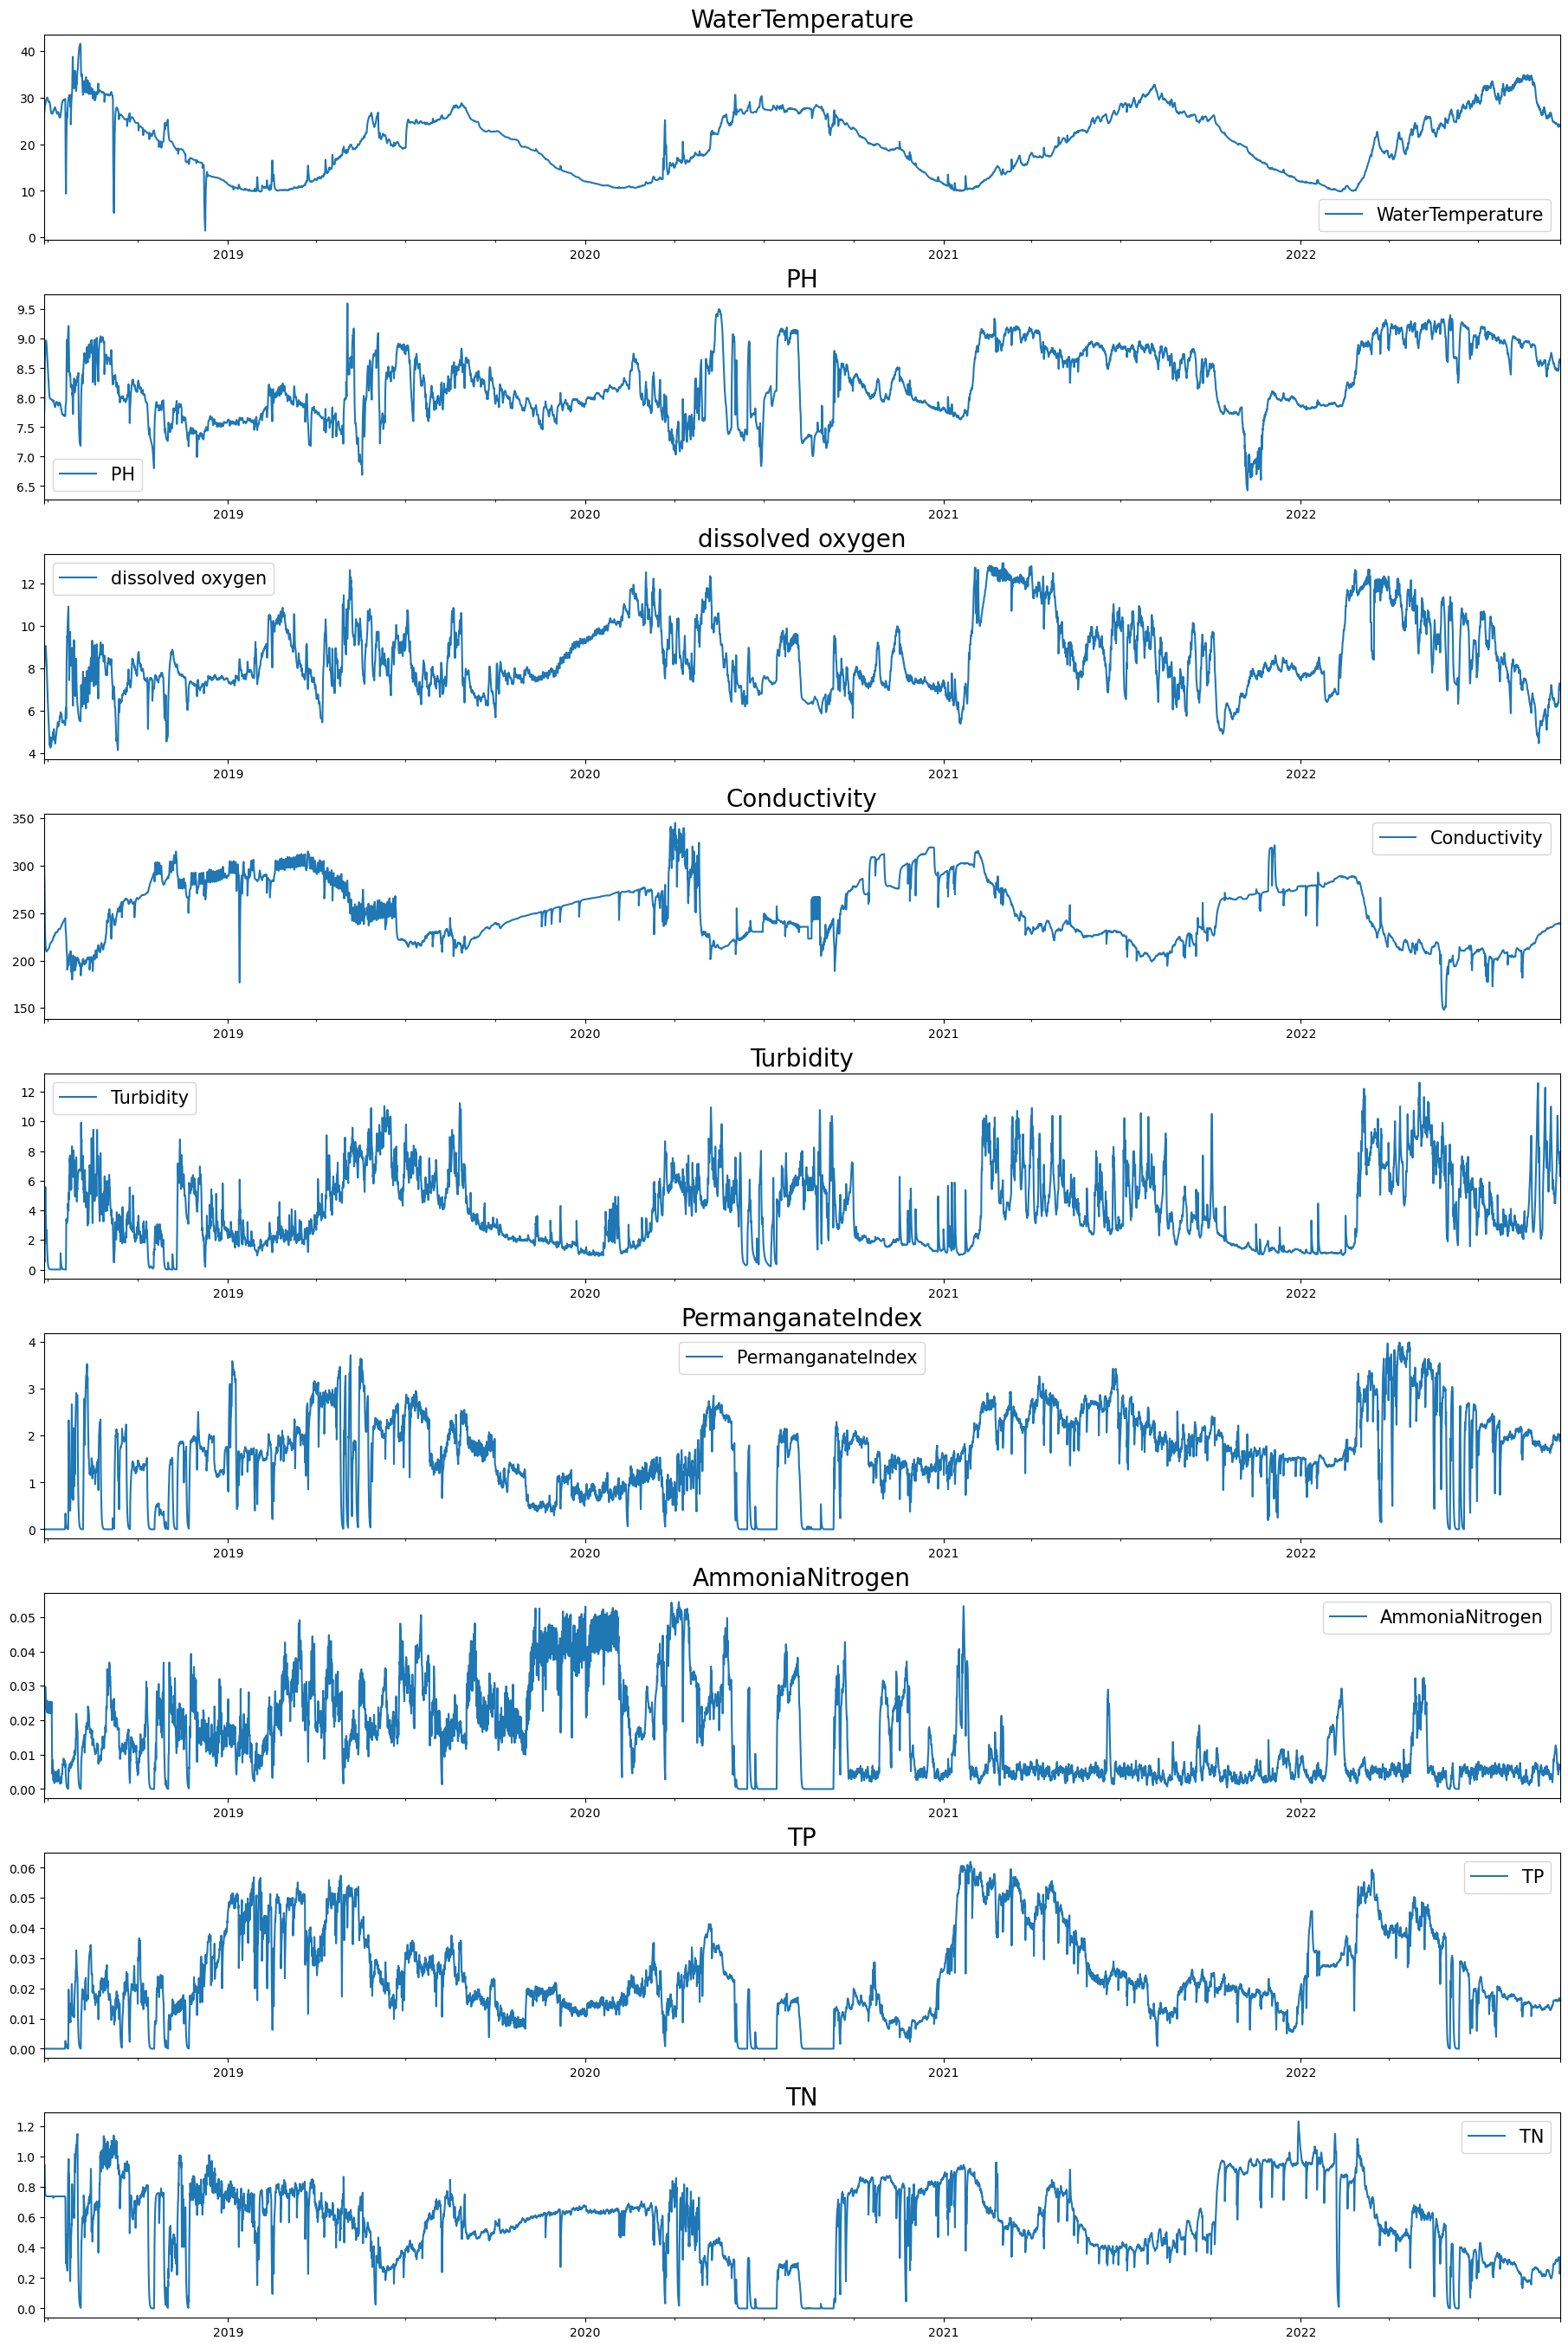

In [22]:
index_nums = len(df.keys())
print(df.keys())
l, h = 18, 3
fig, axis = plt.subplots(index_nums, 1, figsize=(l, h*index_nums), constrained_layout=True)
for i in range(index_nums):
    name = en_keys[i]
    df.plot(y=df.keys()[i], ax=axis[i])
    axis[i].set_title(name, fontsize=20)
    axis[i].set_xlabel('', fontsize=15)
    axis[i].set_ylabel('', fontsize=15)
    
    axis[i].legend([name], fontsize=15)

In [5]:
df['水温'].values.shape[0]

9295

浊度, 9295
[ 0.93173214  0.77343622  0.7092862  ... 12.00909168 11.52631876
  9.01548907]


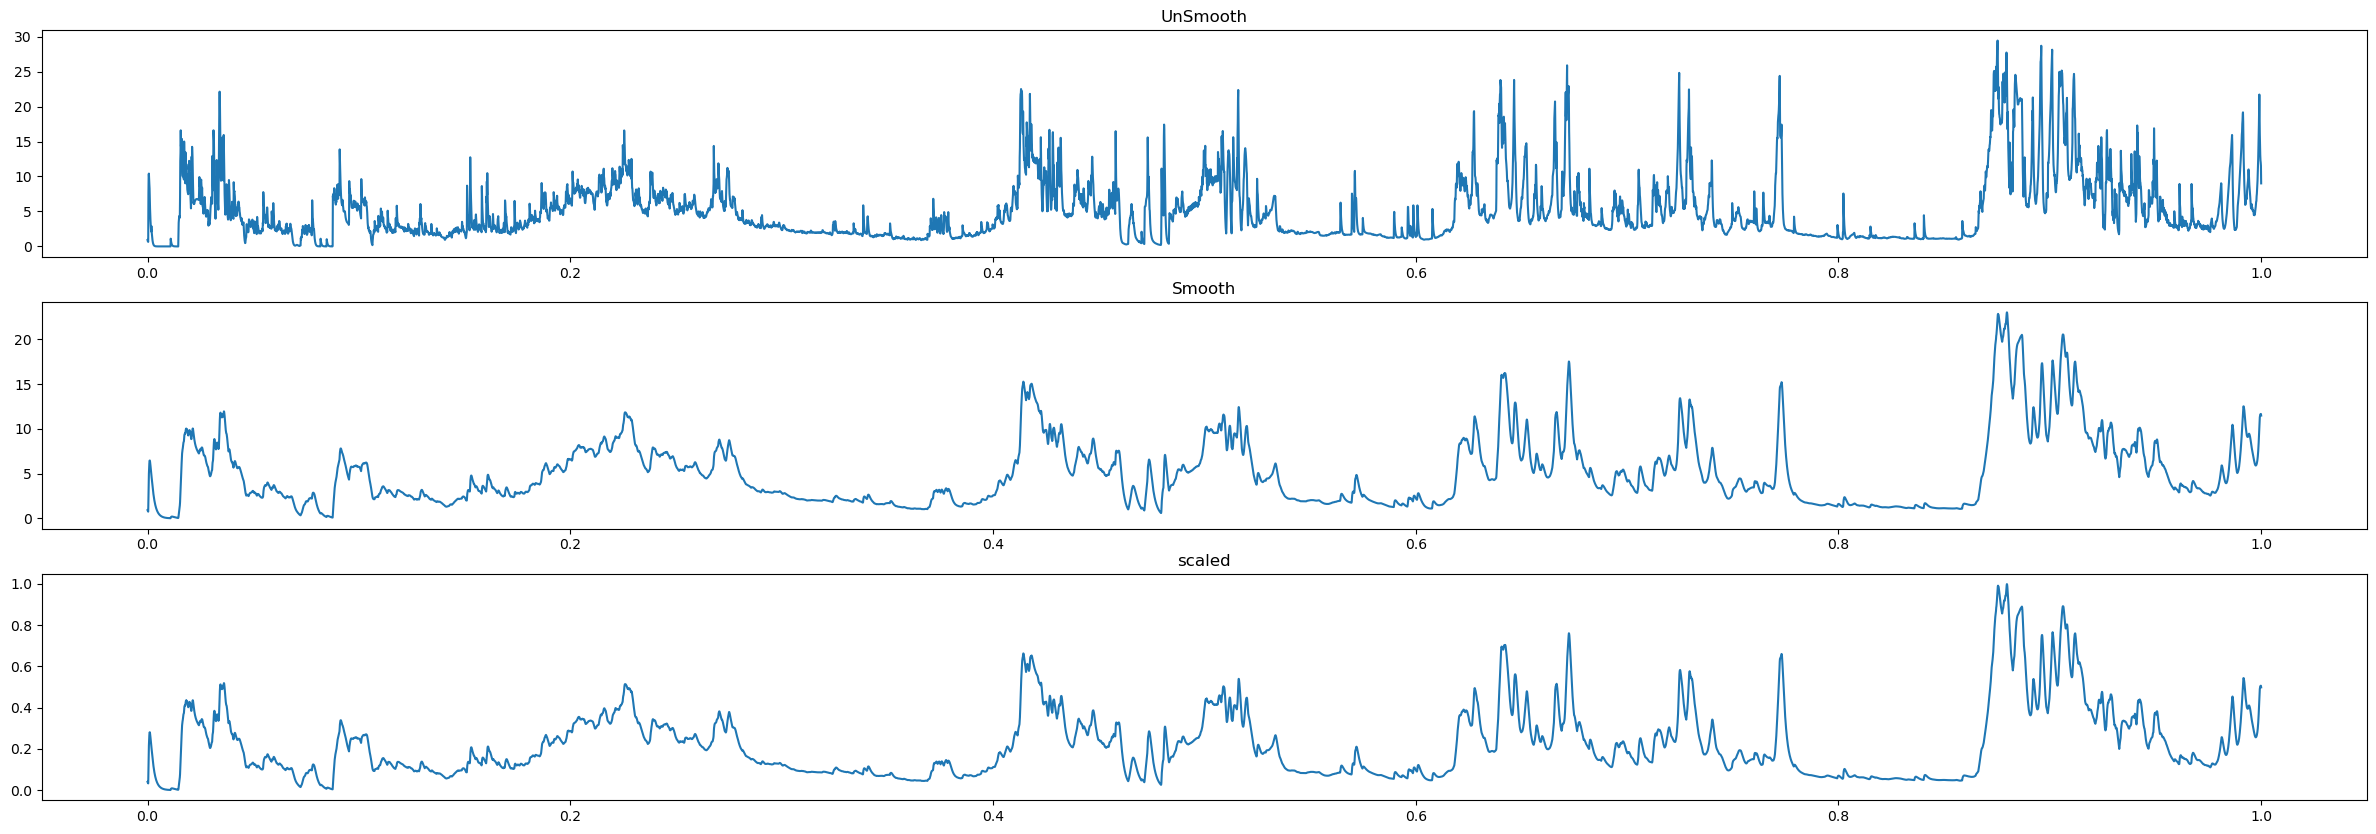

In [6]:
figure, axis = plt.subplots(3, 1, figsize=(30, 10))
name = keys[5]
vals = df[name].values.copy()
print(f'{name}, {len(vals)}')
print(vals)
X = np.linspace(0, 1, len(vals))
axis[0].plot(X, vals)
axis[0].set_title('UnSmooth')
smooth_vals = pd.Series(vals).ewm(span=30).mean()
axis[1].plot(X, smooth_vals)
axis[1].set_title('Smooth')
scaled_vals = (smooth_vals - smooth_vals.min()) / smooth_vals.max()
axis[2].plot(X, scaled_vals)
axis[2].set_title('scaled')


plt.show()